In [119]:
import tensorflow as tf
from tensorflow import keras


if tf.test.gpu_device_name()=='':
    print('You do not have GPU access.')
    !nvidia-smi

else:
  print('You have GPU access')
  !nvidia-smi


# print the tensorflow version
print('TensorFlow {}; Keras {}'.format(tf.__version__, keras.__version__))
tf.test.gpu_device_name()


You have GPU access
Wed Oct 26 15:28:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.72       Driver Version: 512.72       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8     3W /  N/A |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                    

'/device:GPU:0'

| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|    0   N/A  N/A     14060      C   ...nvs\tensorflow\python.exe    N/A      |
+-----------------------------------------------------------------------------+


In [120]:
from tensorflow.keras import layers
import os
import tifffile as tiff
import numpy as np
from matplotlib import pyplot as plt
from keras.models import load_model
from preprocessing import get_model_memory_usage, unpatch_stack

#load pretrained model with 3frame prediction
model_3frame_name = "bactunet_V4_3frame"

model_3frame = load_model("models/"+model_3frame_name+".hdf5", compile=False)


conv2d/kernel:0 (3, 3, 1, 64) conv2d/kernel:0 (3, 3, 3, 64)
conv2d/bias:0 (64,) conv2d/bias:0 (64,)
batch_normalization/gamma:0 (288,) batch_normalization/gamma:0 (288,)
batch_normalization/beta:0 (288,) batch_normalization/beta:0 (288,)
batch_normalization/moving_mean:0 (288,) batch_normalization/moving_mean:0 (288,)
batch_normalization/moving_variance:0 (288,) batch_normalization/moving_variance:0 (288,)
conv2d_1/kernel:0 (3, 3, 64, 64) conv2d_1/kernel:0 (3, 3, 64, 64)
conv2d_1/bias:0 (64,) conv2d_1/bias:0 (64,)
batch_normalization_1/gamma:0 (288,) batch_normalization_1/gamma:0 (288,)
batch_normalization_1/beta:0 (288,) batch_normalization_1/beta:0 (288,)
batch_normalization_1/moving_mean:0 (288,) batch_normalization_1/moving_mean:0 (288,)
batch_normalization_1/moving_variance:0 (288,) batch_normalization_1/moving_variance:0 (288,)
conv2d_2/kernel:0 (3, 3, 64, 128) conv2d_2/kernel:0 (3, 3, 64, 128)
conv2d_2/bias:0 (128,) conv2d_2/bias:0 (128,)
batch_normalization_2/gamma:0 (144,) bat

In [121]:
from preprocessing import patch_image, patch_stack, normalizePercentile, normalizeMinMax
from patchify import patchify

source_path = r"Bactnet/Training data/stacks/"
SIZE = 288

def prepare_data(source_path, PATCH_SIZE, validation=True):
    pred_dict = {}
    if validation:
        prefix = "validation"
    else:
        prefix = "training"
    stacks = os.listdir(os.path.join(source_path, prefix+"_source"))
    image_dataset = None
    mask_dataset = None
    for stack in stacks:
        if (stack.split(".")[-1]=="tif"):
            pred_dict[stack]={}
            img = tiff.imread(os.path.join(source_path, prefix+"_source",stack))
            pred_dict[stack]["image"]=img
            mask = tiff.imread(os.path.join(source_path, prefix+"_target", stack))
            pred_dict[stack]["y_true"]=mask
            print(stack, img.shape, mask.shape)
            
            img_patch = patch_stack(img, PATCH_SIZE)
            if len(mask.shape)==2:
                mask_patch = patch_image(mask, PATCH_SIZE)
            else:    
                mask_patch = patch_stack(mask, SIZE=PATCH_SIZE, DEPTH=1)
            
            print(stack, img_patch.shape, mask_patch.shape)
            mask_patch = normalizeMinMax(mask_patch)
            img_patch = normalizePercentile(img_patch, 0.1, 99.9, clip=True)
            pred_dict[stack]["image_patch"] = img_patch
            pred_dict[stack]["mask_patch"] = mask_patch


            #print(image_dataset.shape, mask_dataset.shape)

    return pred_dict

#pred_dict[file]=[image_stack, mask, patch, y_true, y_pred]
image_dict = prepare_data(source_path, SIZE, validation=True)
image_dict.update(prepare_data(source_path, SIZE, validation=False))
print(image_dict.keys())



BT0403_229.tif (13, 2304, 2304) (11, 2304, 2304)
BT0403_229.tif (704, 3, 288, 288) (704, 1, 288, 288)
BT0407_110.tif (7, 2304, 2304) (5, 2304, 2304)
BT0407_110.tif (320, 3, 288, 288) (320, 1, 288, 288)
BT0398_210.tif (13, 2304, 2304) (11, 2304, 2304)
BT0398_210.tif (704, 3, 288, 288) (704, 1, 288, 288)
BT402_169.tif (5, 2304, 2304) (3, 2304, 2304)
BT402_169.tif (192, 3, 288, 288) (192, 1, 288, 288)
BT403_002.tif (13, 2304, 2304) (11, 2304, 2304)
BT403_002.tif (704, 3, 288, 288) (704, 1, 288, 288)
BT404_199.tif (5, 2304, 2304) (3, 2304, 2304)
BT404_199.tif (192, 3, 288, 288) (192, 1, 288, 288)
dict_keys(['BT0403_229.tif', 'BT0407_110.tif', 'BT0398_210.tif', 'BT402_169.tif', 'BT403_002.tif', 'BT404_199.tif'])


In [124]:
keras.backend.clear_session()
stride = 2
#let's see what happens if you change each of the three frames to zero in order

# #IOU
for stack in image_dict.keys():
    y_pred1 = None
    y_pred2 = None
    y_pred3 = None
    img_stack = image_dict[stack]
    
    #must copy, not chnge array in place
    patch1 = img_stack["image_patch"].copy()
    patch2 = img_stack["image_patch"].copy()
    patch3 = img_stack["image_patch"].copy()
    
    #set one 'channel' to zero
    patch1[:,0,:,:] = 0
    patch2[:,1,:,:] = 0
    patch3[:,2,:,:] = 0
    
    for i in range(0, len(img_stack["image_patch"]), stride):
        pred1 = model_3frame.predict(patch1[i:i+stride])
        pred2 = model_3frame.predict(patch2[i:i+stride])
        pred3 = model_3frame.predict(patch3[i:i+stride])
        
        if y_pred1 is not None:
            y_pred1 = np.concatenate((y_pred1, pred1))
            y_pred2 = np.concatenate((y_pred2, pred2))
            y_pred3 = np.concatenate((y_pred3, pred3))

        if y_pred1 is None:
            y_pred1 = pred1
            y_pred2 = pred2
            y_pred3 = pred3
    
    image_dict[stack]["y_pred_1"] = unpatch_stack(y_pred1, 8, 8, 1)
    image_dict[stack]["y_pred_2"] = unpatch_stack(y_pred2, 8, 8, 1)
    image_dict[stack]["y_pred_3"] = unpatch_stack(y_pred3, 8, 8, 1)
    print(stack, image_dict[stack]["y_pred_1"].shape)
    

BT0403_229.tif (11, 1, 2304, 2304)
BT0407_110.tif (5, 1, 2304, 2304)
BT0398_210.tif (11, 1, 2304, 2304)
BT402_169.tif (3, 1, 2304, 2304)
BT403_002.tif (11, 1, 2304, 2304)
BT404_199.tif (3, 1, 2304, 2304)


In [125]:
threshold = 0.5

for stack in image_dict.keys():
    pred_1 = (image_dict[stack]["y_pred_1"]>threshold)*255
    pred_2 = (image_dict[stack]["y_pred_2"]>threshold)*255
    pred_3 = (image_dict[stack]["y_pred_3"]>threshold)*255
    saveme = np.concatenate((pred_1, pred_2, pred_3, np.expand_dims(image_dict[stack]["y_true"],axis=1)), axis=1)
    saveme = saveme.astype('uint8')
    prefix="V4_frame_zero_"
    dic = unpatch_stack(image_dict[stack]["image_patch"], 8, 8, 3)
    dic = dic[:,1,:,:] * 255
    dic = np.expand_dims(dic, axis=1).astype('uint8')
    print(dic.shape, image_dict[stack]["image_patch"].max())
    saveme = np.concatenate((dic, saveme), axis=1)
    tiff.imwrite(os.path.join(r"C:\Users\Jens\Documents\Code\BactUnet\Bactnet\Training data\stacks\predict", prefix+stack), saveme, imagej=True,
                      metadata={'unit': 'um', 'finterval': 15,
                                'axes': 'TCYX'})

(11, 1, 2304, 2304) 1.0
(5, 1, 2304, 2304) 1.0
(11, 1, 2304, 2304) 1.0
(3, 1, 2304, 2304) 1.0
(11, 1, 2304, 2304) 1.0
(3, 1, 2304, 2304) 1.0


In [143]:
def dice_score(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3) # for easy reading
    return dice    

def iou_score(mask1, mask2):
    intersection = np.logical_and(mask1, mask1)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score
    
dice_dict = {'file':[], 'frame':[], 'condition':[], 'dice_score':[]}
    
for stack in image_dict.keys():
    for frame in range(len(image_dict[stack]['y_pred_1'])):
        for condition in ['y_pred_1','y_pred_2','y_pred_3']:
            dice = dice_score(image_dict[stack][condition][frame], image_dict[stack]['y_true'][frame])
            dice_dict['file'].append(stack)
            dice_dict['frame'].append(frame)
            dice_dict['condition'].append(condition)
            dice_dict['dice_score'].append(dice)


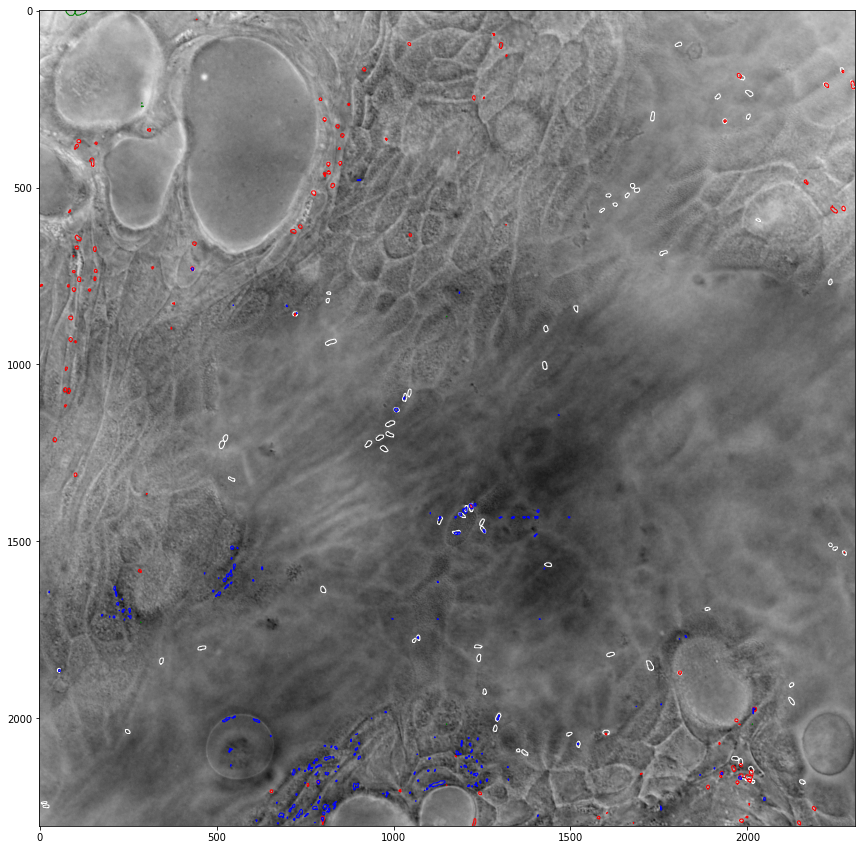

In [140]:
from skimage import measure

threshold = 0.5
stack = 'BT0403_229.tif'
i = 0

contours_true = measure.find_contours(image_dict[stack]['y_true'][i]>1)
contours_1 = measure.find_contours(image_dict[stack]["y_pred_1"][i,0,:,:]>threshold)
contours_2 = measure.find_contours(image_dict[stack]["y_pred_2"][i,0,:,:]>threshold)
contours_3 = measure.find_contours(image_dict[stack]["y_pred_3"][i,0,:,:]>threshold)

fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(image_dict[stack]["image"][i,:,:], cmap='binary')
for contour in contours_true:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='white')
    
for contour in contours_1:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='red')
    
for contour in contours_2:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='green')

for contour in contours_3:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='blue')    


plt.show()



In [144]:
import pandas as pd
import seaborn as sns

dice_df =pd.DataFrame.from_dict(dice_dict)

dice_df.head()

,file,frame,condition,dice_score
0,BT0403_229.tif,0,y_pred_1,0.126
1,BT0403_229.tif,0,y_pred_2,0.000
2,BT0403_229.tif,0,y_pred_3,0.090
3,BT0403_229.tif,1,y_pred_1,0.126
4,BT0403_229.tif,1,y_pred_2,0.000


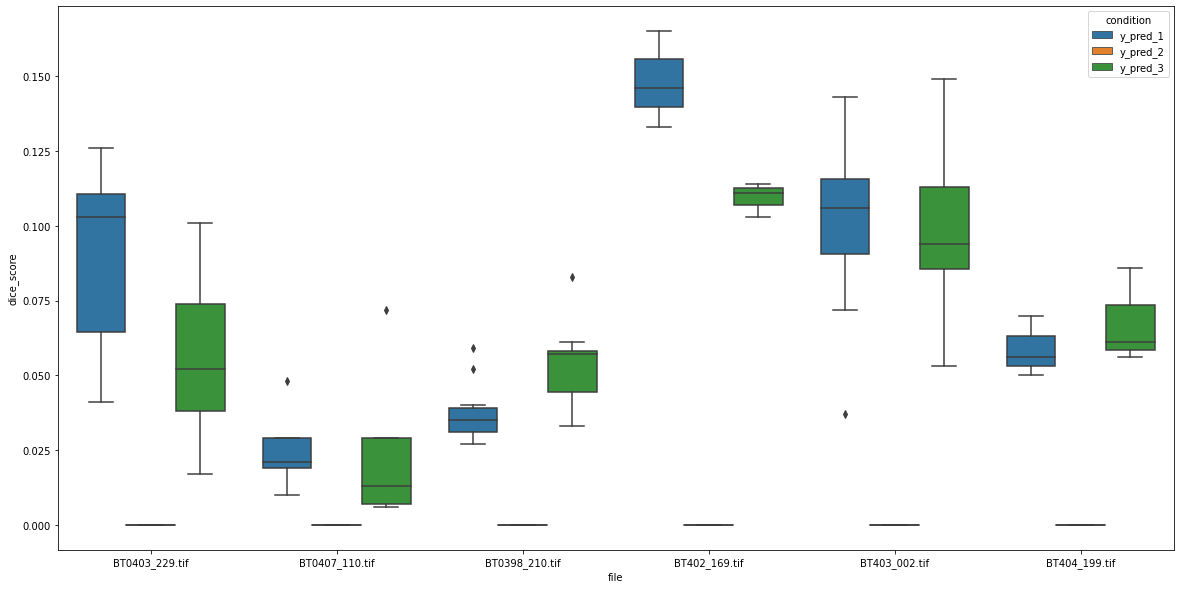

In [145]:
plt.figure(figsize=(20,10))
g1 = sns.boxplot(data=dice_df, x='file', y='dice_score', hue='condition')




All three frames seem to work together to form the segmentation. A manual inspection of all the movies also shows this. As the dice coefficient compare indicates removing the central frame gives basicly no segmetation at all. The threshold value has very little effect. This means that the first & last frames can't be predicted with the 3-frame network. Maybe starting the 3-frame network from the weights of the single frame network, or incorporatng random zeroed N-1 or N+1 frames in the training could fix this?
